Do the imports:

In [1]:
import scipy.integrate as integrate
from scipy.special import comb
import numpy as np
import matplotlib.pyplot as plt

Some possible distributions:

In [2]:
def linear(p):

    """
    Linear pdf

        Parameters
        ----------
        p : a float
            The probability of bit flip

        Returns
        -------
        a value:
            The pdf of linear distribution at p

    """

    return 2 * (1 - p)

def exponential(p):

    """
    Exponential pdf

        Parameters
        ----------
        p : a float
            The probability of bit flip

        Returns
        -------
        a value:
            The pdf of exponential distribution at p

    """

    return (np.e ** (-p)) * (1 / (1 - (1/np.e)))

Maximize $\mathbb{E}[f]$:

In [3]:
def exp_f(distn_function, p, k, N):

    """
    Returns the expressionf for exp f (the integrand)

        Parameters
        ----------
        distn_function : a function
            The probability distribution function over p
        p : a float
            The probability of bit flip
        k : a positive integer <= N
            The number of bit flips away from the encoding of a cell type
        N : A positive integer
            Number of cues in the environment

        Returns
        -------
        a value:
            The integrand in the expression for mean when maximizing exp f

    """
    
    return distn_function(p) * (p ** k) * ((1 - p) ** (N - k))

In [10]:
def maximize_exp_f(M, N, distn_function):

    """
    Input: N, the number of cues in the environment; M, the number of cell types
    Output: An array of integers of length N where the ith index (0-based) is the number of strings i bit-flips away from the intended string that are "rescued"
    """

    mean_terms = []

    for i in range(N + 1):
        mean_i_bit_flip = integrate.quad(lambda p: exp_f(distn_function, p, i, N), 0, 1)[0]
        mean_terms.append(mean_i_bit_flip)

    # the bit flips based on val

    bit_flips = list(range(0, N + 1))
    # sorted_bit_flips = [x for _,x in sorted(zip(mean_terms, bit_flips), reverse = True)]
    # courtesy https://gist.github.com/yangshun/ffaf68380ef71c157c3b
    bit_score_tuples = list(zip(mean_terms, bit_flips))
#     print('Bit scores:')
#     for score, bit in bit_score_tuples:
#         print(bit, ':', score)
    bit_score_tuples.sort(key=lambda x: x[0], reverse=True)
    sorted_bit_flips = [x for _,x in bit_score_tuples]

    quota = int(2 ** N / M)
    filled = 0
    n_choose_k = comb(N, range(N + 1))

    Q_exp_f = [0] * (N + 1)

    for i in range(N + 1):
        if filled + n_choose_k[sorted_bit_flips[i]] <= quota:
            # there is more quota available, so allocate
            Q_exp_f[sorted_bit_flips[i]] = n_choose_k[sorted_bit_flips[i]]
            filled += n_choose_k[sorted_bit_flips[i]]
        else:
            # you can't allocate for the full i
            # so allocate whatever you can
            Q_exp_f[sorted_bit_flips[i]] = quota - filled
            break

    return Q_exp_f

Maximize $\mathbb{E}[\textrm{log}\ f]$:

In [5]:
def exp_log_f(distn_function, p, N, Q_exp_log_f, n_choose_k):

    """
    Returns the original data of each cluster member for a given cluster ID

        Parameters
        ----------
        distn_function : a function
            The probability distribution function over p
        p : a float
            The probability of bit flip
        N : A positive integer
            Number of cues in the environment
        Q_exp_log_f : A one dimensional array (i.e. list)
            The matrix Q so far
        n_choose_k : A list
            nCk for k from 0 to N

        Returns
        -------
        a value:
            The integrand in the expression for mean

    """

    total = 0

    for i in range(N + 1):
        total += Q_exp_log_f[i] * (p ** i) * ((1 - p) ** (N - i))
    
    return distn_function(p) * np.log(total)

In [6]:
def maximize_exp_log_f(M, N, distn_function):

    """
    Returns the original data of each cluster member for a given cluster ID

        Parameters
        ----------
        M: A positive integer
            Number of cell types
        N : A positive integer
            Number of cues in the environment
        distn_function : a function
            The probability distribution function over p

        Returns
        -------
        Q_exp_log_f: An array of integers of length N
            The ith index (0-based) is the number of strings i bit-flips away from the intended string that are "rescued"

    """

    n_choose_k = comb(N, range(N + 1))

    quota = int(2 ** N / M)
    Q_exp_log_f = [0] * (N + 1)
    filled = 0

    # first time has to be done separately

    best_gain = -float('inf')
    best_index = -1

    for i in range(N + 1):
        if Q_exp_log_f[i] < n_choose_k[i]:
            Q_exp_log_f[i] += 1
            new_value = integrate.quad(lambda p: exp_log_f(distn_function, p, N, Q_exp_log_f, n_choose_k), 0, 1)[0]
            gain = new_value
            if gain > best_gain:
                best_gain = gain
                best_index = i
            Q_exp_log_f[i] -= 1
        
    Q_exp_log_f[best_index] += 1
    current_value = integrate.quad(lambda p: exp_log_f(distn_function, p, N, Q_exp_log_f, n_choose_k), 0, 1)[0]
    filled += 1

    # you have to allocate each string by hand

    while filled < quota:

        best_gain = -float('inf')
        best_index = -1

        for i in range(N + 1):
            if Q_exp_log_f[i] < n_choose_k[i]:
                Q_exp_log_f[i] += 1
                new_value = integrate.quad(lambda p: exp_log_f(distn_function, p, N, Q_exp_log_f, n_choose_k), 0, 1)[0]
                gain = new_value - current_value
                if gain > best_gain:
                    best_gain = gain
                    best_index = i
                Q_exp_log_f[i] -= 1
        
        Q_exp_log_f[best_index] += 1
        current_value = integrate.quad(lambda p: exp_log_f(distn_function, p, N, Q_exp_log_f, n_choose_k), 0, 1)[0]
        filled += 1

    return Q_exp_log_f

M: 5 N: 5
Maximizing exp f...
Maximizing exp log f...


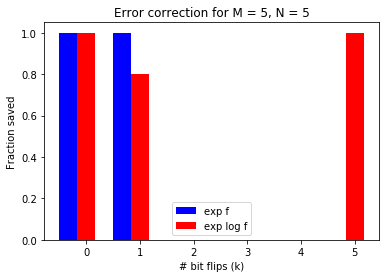

---------------------------------------------------
M: 5 N: 7
Maximizing exp f...
Maximizing exp log f...


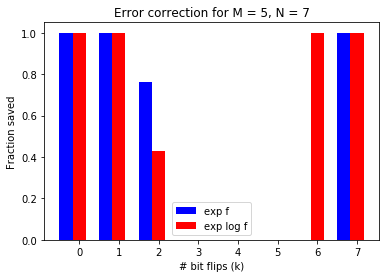

---------------------------------------------------
M: 5 N: 9
Maximizing exp f...
Maximizing exp log f...


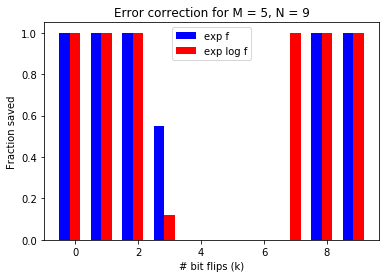

---------------------------------------------------
M: 5 N: 10
Maximizing exp f...
Maximizing exp log f...


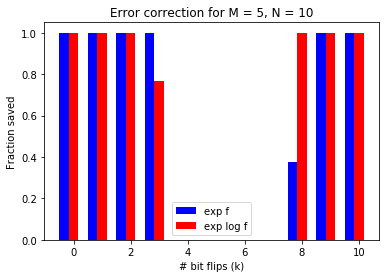

---------------------------------------------------
M: 5 N: 13
Maximizing exp f...
Maximizing exp log f...


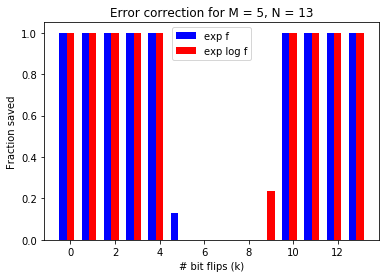

---------------------------------------------------
M: 10 N: 5
Maximizing exp f...
Maximizing exp log f...


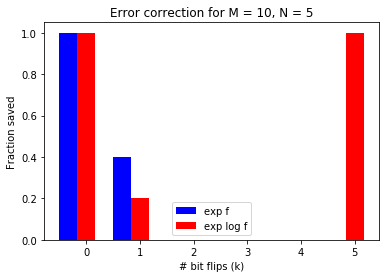

---------------------------------------------------
M: 10 N: 7
Maximizing exp f...
Maximizing exp log f...


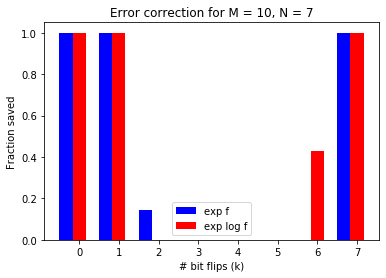

---------------------------------------------------
M: 10 N: 9
Maximizing exp f...
Maximizing exp log f...


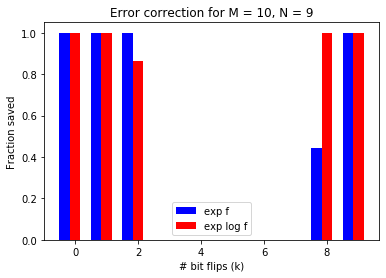

---------------------------------------------------
M: 10 N: 10
Maximizing exp f...
Maximizing exp log f...


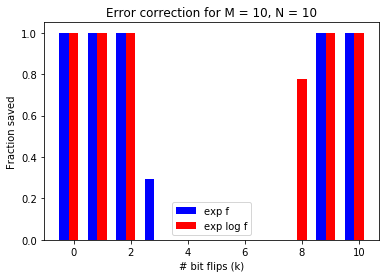

---------------------------------------------------
M: 10 N: 13
Maximizing exp f...
Maximizing exp log f...


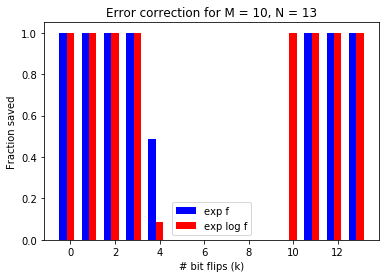

---------------------------------------------------
M: 15 N: 5
Maximizing exp f...
Maximizing exp log f...


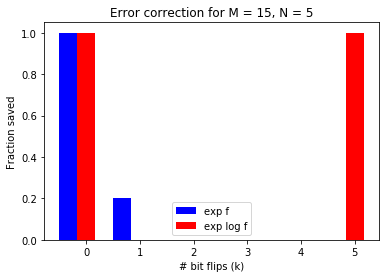

---------------------------------------------------
M: 15 N: 7
Maximizing exp f...
Maximizing exp log f...


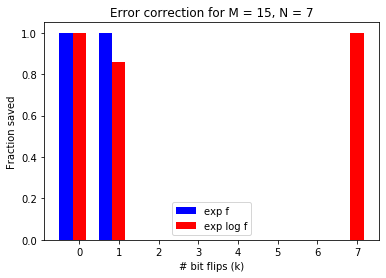

---------------------------------------------------
M: 15 N: 9
Maximizing exp f...
Maximizing exp log f...


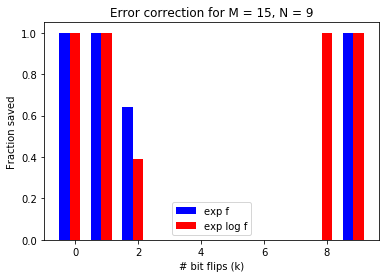

---------------------------------------------------
M: 15 N: 10
Maximizing exp f...
Maximizing exp log f...


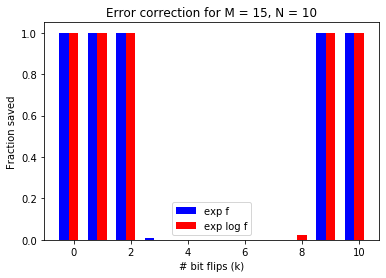

---------------------------------------------------
M: 15 N: 13
Maximizing exp f...
Maximizing exp log f...


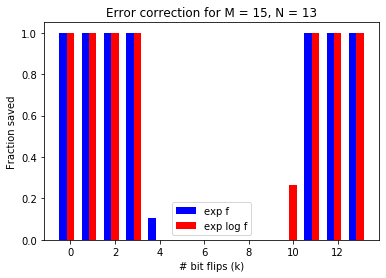

---------------------------------------------------


In [15]:
# M_array = [10]
# N_array = [10]
M_array = [5, 10, 15]
N_array = [5, 7, 9, 10, 13]

distn_function = linear

for M in M_array:
    for N in N_array:
        print('M:', M, 'N:', N)
        print('Maximizing exp f...')
        exp_f_arr = np.array(maximize_exp_f(M, N, distn_function))
#         print(maximize_exp_f(M, N, exponential))
        print('Maximizing exp log f...')
        exp_log_f_arr = np.array(maximize_exp_log_f(M, N, distn_function))
#         print(maximize_exp_log_f(M, N, exponential))
        n_choose_k = np.array(comb(N, range(N + 1)))
        bins = np.array(list(range(N + 1)))
        width = np.min(np.diff(bins))/3
        plt.bar(bins - width, exp_f_arr/n_choose_k, width, color='b', label='exp f') 
        plt.bar(bins, exp_log_f_arr/n_choose_k, width, color='r', label='exp log f')
        plt.title('Error correction for M = ' + str(M) + ', N = ' + str(N))
        plt.xlabel('# bit flips (k)')
        plt.ylabel('Fraction saved')
        plt.legend(['exp f', 'exp log f'])
        plt.show()
        print('---------------------------------------------------')
        
